In [76]:
% pylab inline
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pylab as pb
from matplotlib import cm
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [84]:
# Logistic function
def logisFunc(a):
    ret = 1.0/(1.0 + np.exp(-a))
    return ret

    # Extracting the class wich probability is the highest
def extractMax(Yestim, nclass):
    for i in range(len(Yestim[:,0])):
        mayor = -1000000.0
        idmayor = -1
        for j in range(nclass):
            if(Yestim[i,j] > mayor):
                mayor = Yestim[i,j]
                idmayor = j

        for j in range(nclass):
            if (j == idmayor):
                Yestim[i,j] = 1.
            else:
                Yestim[i,j] = 0.
    return Yestim

    # Evaluating accuracy of a preditcion
def evalAccuracy(Yestim, Tvalid, nclass):
    true_positives = np.array([0.,0.,0.])
    true_negatives = np.array([0.,0.,0.])
    false_positives = np.array([0.,0.,0.])
    false_negatives = np.array([0.,0.,0.])
    for i in range(len(Yestim[:,0])):
        for j in range(nclass):
            if(Tvalid[i,j] == 1. and Tvalid[i,j] == Yestim[i,j]):
                true_positives[j] += 1.
            if(Tvalid[i,j] == 0. and Tvalid[i,j] == Yestim[i,j]):
                true_negatives[j] += 1.
            if(Tvalid[i,j] == 0. and Yestim[i,j] == 1.):
                false_positives[j] += 1.
            if(Tvalid[i,j] == 1. and Yestim[i,j] == 0):
                false_negatives[j] += 1.

    ret = np.sum(true_positives + true_negatives)/np.sum(true_positives + false_positives + false_negatives + true_negatives)
    ret_class1 = (true_positives[0] + true_negatives[0])/(true_positives[0] + false_positives[0] + false_negatives[0] + true_negatives[0])
    return ret, ret_class1

def logRegEstim(X,T, Xtest):
    PHI = X
    N = X.shape[0]
    M = X.shape[1]
    #Wold = np.transpose(np.matrix(np.random.random_sample(M)))
    Wold = np.transpose(np.matrix(np.zeros(M))) + 0.001
    Wnew = np.transpose(np.matrix(np.zeros(M)))
    EPS = 1e-6
    diff = np.linalg.norm(Wold - Wnew)
    cont = 0
    Yestim = T
    var_0 = 10.0
    S0 = np.eye(M)*var_0
    mean_0 = np.zeros(M)
    
    x, y = np.mgrid[-10:10:.01, -10:10:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = stats.multivariate_normal(mean_0, S0)
    plt.contourf(x, y, rv.pdf(pos))
    
    S0 = np.matrix(S0)
    mean_0 = mean_0[:,None]
    mean_0 = np.matrix(mean_0)
    
    # Newton raphson with several iteration
    super_R = 0
    while cont < 100:
        yy = np.transpose(Wold) * np.transpose(PHI)
        yy = np.transpose(logisFunc(yy))
        yy = yy
        Yestim = yy
        #print ' '
        R = np.zeros((N,N))
        for i in range(0,N):
            #print yy[i,0]
            R[i,i] = (yy[i,0] * (1 - yy[i,0])) + 0.001
        super_R = R
        #z = (PHI*Wold) - (np.linalg.inv(R)*(yy - T))
        #Wnew = np.linalg.inv((np.transpose(PHI) * (R * PHI))) * (np.transpose(PHI)*R*z)
        tmp1 = (np.linalg.inv(S0) + np.transpose(PHI)*(R*PHI))
        tmp2 = (np.linalg.inv(S0)*(Wold - mean_0) + np.transpose(PHI)*(yy - T))
        #print tmp1.shape, tmp2.shape
        Wnew = Wold - (np.linalg.inv(tmp1)*(tmp2))
        diff = np.linalg.norm(Wold - Wnew)
        if diff < EPS:
            break
        else:
            Wold = Wnew
        cont += 1
    print Wnew
    cov_mat = np.linalg.inv(S0) +   np.transpose(PHI)*(super_R*PHI)
    #print Xtest.shape
    ret = np.transpose(Wnew) * np.transpose(Xtest)
    ret = np.transpose(logisFunc(ret))
    #print ret.shape
    return Wnew, cov_mat


[[ 3.56118509]
 [-3.51357427]]


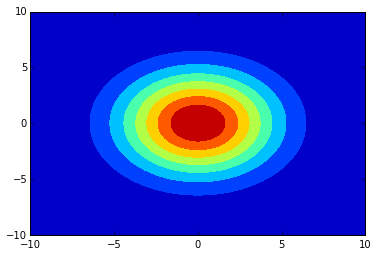

In [85]:
mdict = scipy.io.loadmat('ejemplo_class_uno.mat')
X = mdict['X'] 
t = mdict['t']
for i in range(0,t.shape[0]):
    if(t[i] == 1):
        t[i] = 0
    if(t[i] == -1):
        t[i] = 1
X = np.matrix(X)
T = np.matrix(t)
posterior = logRegEstim(X,T,X)

<matplotlib.contour.QuadContourSet instance at 0x14413f128>

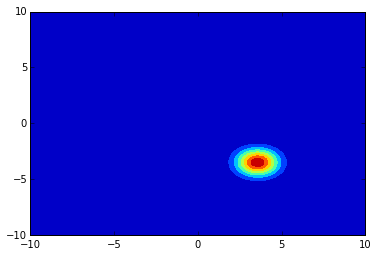

In [108]:
mean_posterior = posterior[0]
cov_posterior = posterior[1]
coma_h = np.zeros(2)
coma_h[0] = mean_posterior[0][0]
coma_h[1] = mean_posterior[1][0]
#cov_posterior.flatten()
x, y = np.mgrid[-10:10:.01, -10:10:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = stats.multivariate_normal(coma_h,cov_posterior)
plt.contourf(x, y, rv.pdf(pos))